In [1]:
import numpy as np
import pandas as pd
from scipy import interpolate
from scipy import optimize
from scipy import signal
from numpy import fft
from detect_peaks import detect_peaks

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def sdh_load(year, num, plot=True):
    """ Loads delimited text frequency vs. field data
    First column: Frequency
    Second column: Field
    Returns: dict containing a DataFrame for both up and down sweeps
    """
    fileu = 'Jun'+str(year)+'_2002s0'+str(num)+'u.txt'
    filed = 'Jun'+str(year)+'_2002s0'+str(num)+'d.txt'
    col_names = ['Freq', 'Field']
    df_sdhu = pd.read_csv(fileu, sep='\t')
    df_sdhd = pd.read_csv(filed, sep='\t')
    df_sdhu.columns = col_names
    df_sdhd.columns = col_names
    df_sdhu = pd.DataFrame({'Freq': df_sdhu.Freq, 'Field': df_sdhu.Field, 'InvField':1/df_sdhu.Field[::-1]})
    df_sdhd = pd.DataFrame({'Freq': df_sdhd.Freq, 'Field': df_sdhd.Field, 'InvField':1/df_sdhd.Field[::-1]})
    
    sdh_dict = {'Up': df_sdhu, 'Down': df_sdhd}
    if plot:
        plt.plot(df_sdhu.Field, 1e-6*df_sdhu.Freq, label='Up')
        plt.plot(df_sdhd.Field, 1e-6*df_sdhd.Freq, label='Down')
        plt.xlim(0)
        plt.xlabel('Field (T)')
        plt.ylabel('Frequency (MHz)')
        plt.legend(loc=0)
        plt.show()
    return sdh_dict

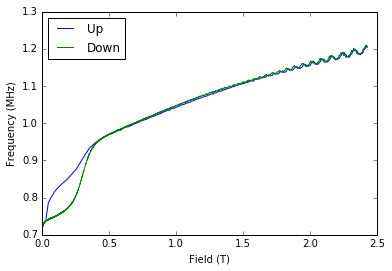

In [3]:
sdh15_3 = sdh_load(15,3)

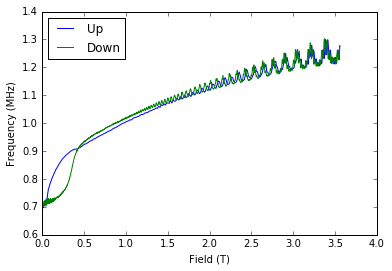

In [4]:
sdh15_4 = sdh_load(15,4)

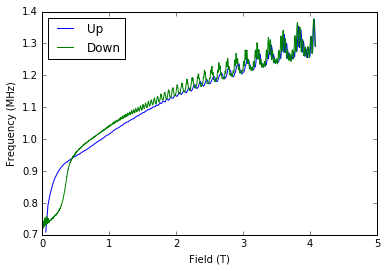

In [5]:
sdh15_5 = sdh_load(15,5)

In [6]:
def back_subtract(sdh_dict, deg, Bmin, Bmax, npnts=2**13, plot=True, yscale=1e5, save=False):
    df_up = sdh_dict['Up']
    df_down = sdh_dict['Down']
    Binv = np.linspace(1/Bmax, 1/Bmin, npnts)
    tck = interpolate.splrep(df_up.InvField[df_up.InvField>=1/Bmax][df_up.InvField<=1/Bmin].values[::-1],
                             df_up.Freq[df_up.InvField>=1/Bmax][df_up.InvField<=1/Bmin].values[::-1], s=0)
    new_up = interpolate.splev(Binv, tck, der=0)
    df_splup = pd.DataFrame({'Freq': new_up, 'Field': 1/Binv, 'InvField': Binv})
    
    tck = interpolate.splrep(df_down.InvField[df_down.InvField>=1/Bmax][df_down.InvField<=1/Bmin].values[::-1],
                             df_down.Freq[df_down.InvField>=1/Bmax][df_down.InvField<=1/Bmin].values[::-1], s=0)
    new_down = interpolate.splev(Binv, tck, der=0)
    df_spldown = pd.DataFrame({'Freq': new_down, 'Field': 1/Binv, 'InvField': Binv})
    
    coeffup = np.polyfit(df_up.InvField[df_up.InvField>=1/Bmax][df_up.InvField<=1/Bmin],
                       df_up.Freq[df_up.InvField>=1/Bmax][df_up.InvField<=1/Bmin], deg)
    coeffdown = np.polyfit(df_down.InvField[df_down.InvField>=1/Bmax][df_down.InvField<=1/Bmin],
                       df_down.Freq[df_down.InvField>=1/Bmax][df_down.InvField<=1/Bmin], deg)
    fitup = np.polyval(coeffup, Binv)
    fitdown = np.polyval(coeffdown, Binv)
    sub_up = new_up-fitup
    sub_down = new_down-fitdown
    if plot:
        plt.plot(Binv, 1e-3*sub_down, 'b', label='Down')
        plt.plot(Binv, 1e-3*sub_up, 'r', label='Up')
        plt.xlim(1/Bmax, 1/Bmin)
        plt.ylim(-yscale*1e-3,yscale*1e-3)
        plt.legend(loc=0)
        plt.xlabel(r'Inverse Field (T${}^{-1}$)')
        plt.ylabel(r'$\Delta$f (kHz)')
        plt.show()
    if save:
        sdh_dict.update({'Upcs': pd.DataFrame({'Field': 1/Binv, 'InvField': Binv,
                                     'Freq': new_up, 'FreqSub': sub_up}),
                    'Downcs': pd.DataFrame({'Field': 1/Binv, 'InvField': Binv,
                                        'Freq': new_down, 'FreqSub': sub_down})})
        print('Dict updated.\nKeys:',sdh_dict.keys())
        return sdh_dict

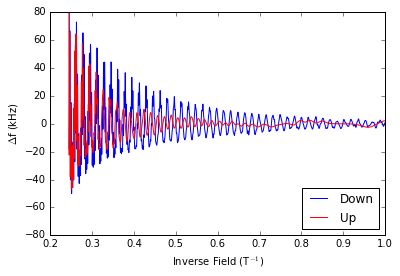

Dict updated.
Keys: dict_keys(['Downcs', 'Upcs', 'Up', 'Down'])


In [7]:
sdh15_5 = back_subtract(sdh15_5, 7, 1, 5, yscale=8e4, save=True)

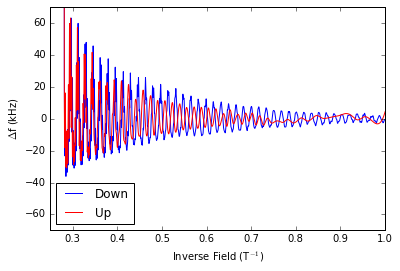

Dict updated.
Keys: dict_keys(['Downcs', 'Upcs', 'Up', 'Down'])


In [8]:
sdh15_4 = back_subtract(sdh15_4, 5, 1, 4, yscale=7e4, save=True)

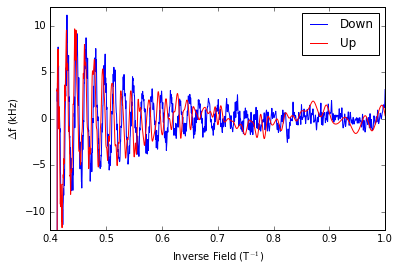

Dict updated.
Keys: dict_keys(['Downcs', 'Upcs', 'Up', 'Down'])


In [9]:
sdh15_3 = back_subtract(sdh15_3, 7, 1, 2.5, yscale=1.2e4, save=True)

In [10]:
def get_fft_peaks(sdh_dict, direc='Down', nskip=500, mph=None, mpd=1,
                  threshold=0, edge='rising', kpsh=False, valley=False,
                  show=True, ax=None, nignore=5, xmax=None, keep_ind=None, save=False):
    direc = direc+'cs'
    dt = sdh_dict[direc].InvField[1]-sdh_dict[direc].InvField[0]
    freq_data = sdh_dict[direc].FreqSub[nskip:]
    inv_field = sdh_dict[direc].InvField[nskip:]
    fftdata = abs(fft.rfft(freq_data))
    f = fft.rfftfreq(len(freq_data), d=dt)
    peak_ind = detect_peaks(fftdata, mph, mpd, threshold, edge, kpsh, valley, show, ax, nignore, xmax, keep_ind)
    
    df_peaks = pd.DataFrame({'Freq': [f[i] for i in peak_ind], 'Amp': [fftdata[i] for i in peak_ind],
                             'Ind': [i for i in peak_ind]})
    if save:
        sdh_dict.update({'Peaks': df_peaks, 'nskip': nskip})
        print('The following {} peaks have been added to the dict:'.format(len(df_peaks)))
        print(df_peaks,'\n')
        print('Keys:', sdh_dict.keys())
        return sdh_dict
    print(df_peaks)

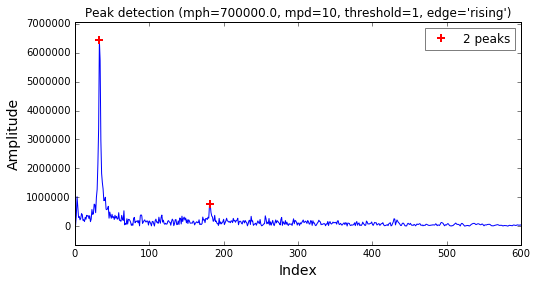

The following 2 peaks have been added to the dict:
            Amp        Freq  Ind
0  6.433178e+06   58.567993   33
1  7.528143e+05  323.011354  182 

Keys: dict_keys(['nskip', 'Peaks', 'Downcs', 'Upcs', 'Up', 'Down'])


In [11]:
sdh15_3 = get_fft_peaks(sdh15_3, direc='Down', mph=7e5, mpd=10, threshold=1, xmax=600, keep_ind=None, save=True)

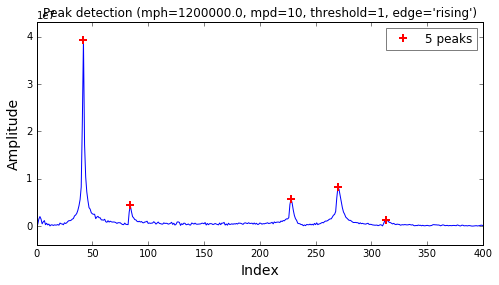

The following 5 peaks have been added to the dict:
            Amp        Freq  Ind
0  3.922456e+07   59.632865   42
1  4.373855e+06  119.265731   84
2  5.808526e+06  323.721269  228
3  8.204964e+06  383.354134  270
4  1.389898e+06  444.406830  313 

Keys: dict_keys(['nskip', 'Peaks', 'Downcs', 'Upcs', 'Up', 'Down'])


In [12]:
sdh15_4 = get_fft_peaks(sdh15_4, mph=1.2e6, mpd=10, threshold=1, xmax=400, keep_ind=[0,2,3,4,6], save=True)

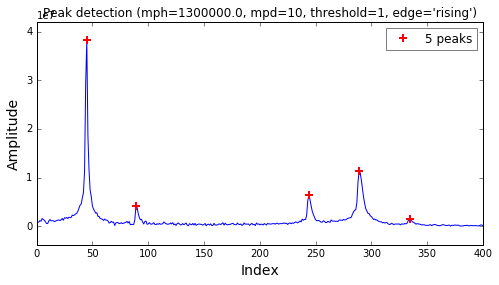

The following 5 peaks have been added to the dict:
            Amp        Freq  Ind
0  3.821862e+07   59.899083   45
1  4.076265e+06  118.467076   89
2  6.345393e+06  324.786141  244
3  1.135239e+07  384.685225  289
4  1.425762e+06  445.915399  335 

Keys: dict_keys(['nskip', 'Peaks', 'Downcs', 'Upcs', 'Up', 'Down'])


In [13]:
sdh15_5 = get_fft_peaks(sdh15_5, mph=1.3e6, mpd=10, threshold=1, xmax=400, keep_ind=[1,3,4,6,8], save=True)

In [14]:
def bandpass(lowcut, highcut, fs, order=2):
    nyq = fs/2
    low = lowcut/nyq
    high = highcut/nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(freq_data, lowcut, highcut, fs, order=2):
    b, a = bandpass(lowcut, highcut, fs, order=order)
    freq_filt = signal.filtfilt(b, a, freq_data)
    return freq_filt

def isolate_orbit(sdh_dict, center_freq, passband, orbit, order=2, direc='Down', plot=True, save=False):
    nskip = sdh_dict['nskip']
    direc = direc+'cs'
    freq_data = sdh_dict[direc].FreqSub.values[nskip:]
    inv_field = sdh_dict[direc].InvField.values[nskip:]
    fs = 1/(inv_field[1]-inv_field[0])
    lowcut, highcut = center_freq-passband, center_freq+passband
    freq_filt = bandpass_filter(freq_data, lowcut, highcut, fs, order=order)
    if plot:
        plt.plot(sdh_dict[direc].InvField[nskip:], 1e-3*sdh_dict[direc].FreqSub[nskip:], label='Raw')
        plt.plot(sdh_dict[direc].InvField[nskip:], 1e-3*freq_filt, 'r', label='{} T bandpass'.format(center_freq))
        plt.xlabel(r'Inverse Field (T${}^{-1}$)')
        plt.ylabel(r'$\Delta$f (kHz)')
        plt.legend(loc=0)
        plt.show()
    if save:
        sdh_dict.update({orbit: {'Freq': freq_filt}})
        print('Filtered '+orbit+' orbit has been added to the dict.')
        print('Keys: ', sdh_dict.keys())
        return sdh_dict

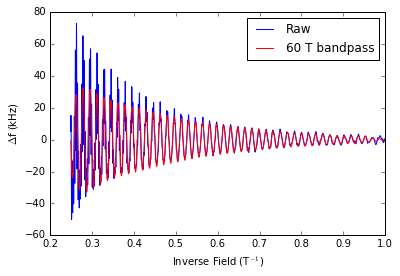

Filtered 60 T orbit has been added to the dict.
Keys:  dict_keys(['nskip', 'Peaks', '60 T', 'Downcs', 'Upcs', 'Up', 'Down'])


In [15]:
center_freq = 60
passband = 10
orbit = '60 T'
sdh15_5 = isolate_orbit(sdh15_5, center_freq, passband, orbit, save=True)

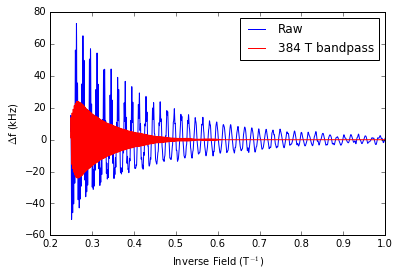

Filtered 384 T orbit has been added to the dict.
Keys:  dict_keys(['nskip', 'Peaks', '60 T', 'Downcs', '384 T', 'Upcs', 'Up', 'Down'])


In [16]:
center_freq = 384
passband = 20
orbit = '384 T'
sdh15_5 = isolate_orbit(sdh15_5, center_freq, passband, orbit, save=True)

In [17]:
def get_peak_amplitudes(sdh_dict, orbit, direc='Down', show=True, save=True):
    nskip = sdh_dict['nskip']
    direc = direc+'cs'
    peaks = abs(sdh_dict[orbit]['Freq'])
    peak_ind = detect_peaks(peaks, show=show)
    peak_fields = np.array([sdh_dict[direc].InvField[nskip+i] for i in peak_ind])
    peak_amps = np.array([peaks[i] for i in peak_ind])
    if save:
        print('Peak amplitudes of '+orbit+' orbit have been added to the dict.')
        print('Keys: ', sdh_dict.keys())
        df_peaks = pd.DataFrame({'Amp': peak_amps, 'InvField': peak_fields})
        sdh_dict[orbit].update({'Peaks': df_peaks})
        plt.plot(peak_fields, 1e-3*peak_amps, 'o')
        plt.xlabel(r'Inverse Field (T${}^{-1}$)')
        plt.ylabel(r'Amplitude (kHz)')
        plt.show()
        return sdh_dict

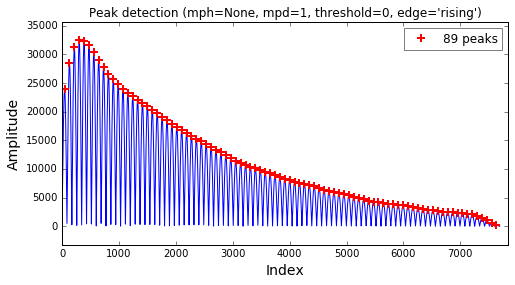

Peak amplitudes of 60 T orbit have been added to the dict.
Keys:  dict_keys(['nskip', 'Peaks', '60 T', 'Downcs', '384 T', 'Upcs', 'Up', 'Down'])


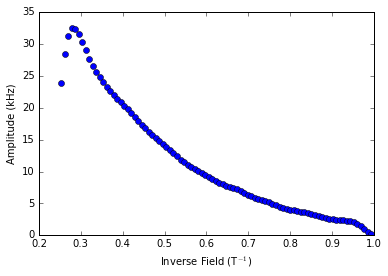

In [18]:
sdh15_5 = get_peak_amplitudes(sdh15_5, '60 T')

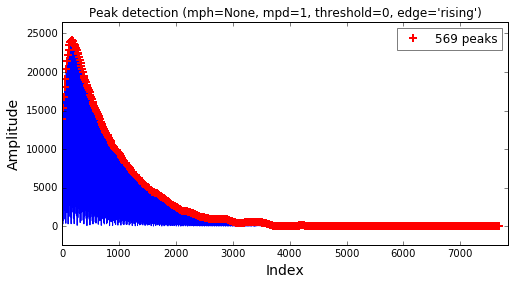

Peak amplitudes of 384 T orbit have been added to the dict.
Keys:  dict_keys(['nskip', 'Peaks', '60 T', 'Downcs', '384 T', 'Upcs', 'Up', 'Down'])


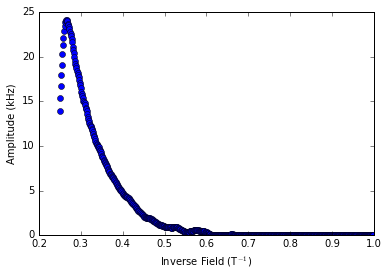

In [19]:
sdh15_5 = get_peak_amplitudes(sdh15_5, '384 T')